In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models/saved')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
tabular_path = DATA_DIR / 'tabular_ml_ready.parquet'
df = pd.read_parquet(tabular_path)
feature_cols = [c for c in df.columns if c not in ['burnout_level', 'burnout_score']]
X = df[feature_cols].values.astype(np.float32)
y = df['burnout_level'].values.astype(np.int64)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train).astype(np.float32)
X_val = scaler.transform(X_val).astype(np.float32)
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))

In [3]:
class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.from_numpy(features)
        self.y = torch.from_numpy(labels)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
train_ds = TabularDataset(X_train, y_train)
val_ds = TabularDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256)
            , nn.BatchNorm1d(256)
            , nn.ReLU()
            , nn.Dropout(0.3)
            , nn.Linear(256, 128)
            , nn.BatchNorm1d(128)
            , nn.ReLU()
            , nn.Dropout(0.2)
            , nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, num_classes).to(DEVICE)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_patience = 8
best_val = float('inf')
patience = 0
history = {'train_loss': [], 'val_loss': []}

In [8]:
EPOCHS = 80
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    scheduler.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        patience = 0
        torch.save({
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss
        }, MODEL_DIR / 'mlp_classifier.pt')
    else:
        patience += 1
        if patience >= early_patience:
            print(f'Early stop at epoch {epoch}')
            break
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f}')

Epoch 5: train=0.1083 val=0.0606
Epoch 10: train=0.0920 val=0.0516
Epoch 10: train=0.0920 val=0.0516
Epoch 15: train=0.0872 val=0.0542
Epoch 15: train=0.0872 val=0.0542
Epoch 20: train=0.0808 val=0.0492
Epoch 20: train=0.0808 val=0.0492
Epoch 25: train=0.0792 val=0.0480
Epoch 25: train=0.0792 val=0.0480
Epoch 30: train=0.0795 val=0.0547
Epoch 30: train=0.0795 val=0.0547
Early stop at epoch 35
Early stop at epoch 35


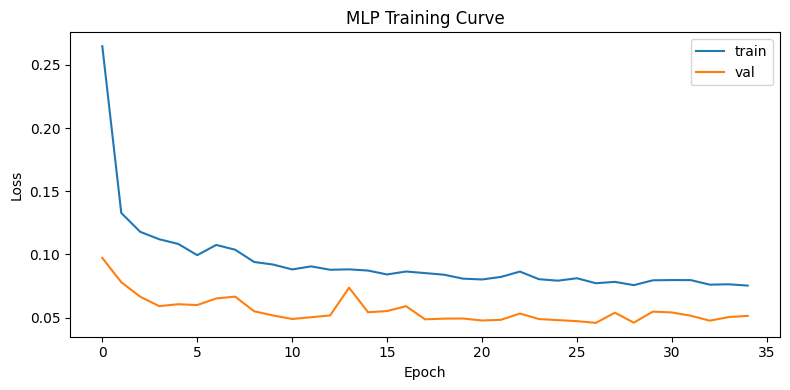

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('MLP Training Curve')
plt.tight_layout()

In [12]:
# Fix for PyTorch >= 2.6 default security setting
# We trust this file since we just created it.
checkpoint = torch.load(MODEL_DIR / 'mlp_classifier.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state'])
model.eval()

with torch.no_grad():
    xb = torch.from_numpy(X_val).to(DEVICE)
    logits = model(xb)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

acc = accuracy_score(y_val, preds)
f1 = f1_score(y_val, preds, average='macro')
print({'accuracy': acc, 'f1_macro': f1})
print(classification_report(y_val, preds))

{'accuracy': 0.9883809523809524, 'f1_macro': 0.9883508732823283}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6928
           1       0.98      0.98      0.98      6932
           2       0.99      0.99      0.99      7140

    accuracy                           0.99     21000
   macro avg       0.99      0.99      0.99     21000
weighted avg       0.99      0.99      0.99     21000

